<h1 style = "text-align:center">0. Introdução</h1>

<img style = "height: 400px" src="https://besthotelshome.com/wp-content/uploads/2020/04/Large-group-of-people-seen-from-above-gathered-together-in-the-shape-of-United-States-of-America-map.jpg">

Neste projeto, vamos fazer uma análise dos dados coletados a partir do censo de 1994 dos EUA.
<br>

Além disso, o objetivo é construir um modelo de Machine Learning que consiga prever, a partir das características de cada indivíduo, se essa pessoa faz mais de $ 50K por ano.
<br>

A partir da análise exploratória dos dados, queremos responder as seguintes perguntas:

<ol>
    <li> Há um salto muito grande no salário de bacharéis, mestres e doutores?
    <li> O valor da hora trabalhada aumenta com o aumento da escolaridade? 
    <li> Solteiros ganham mais que pessoas em algum tipo de relacionamento?
    <li> Com o aumento do nível de escolaridade, a proporção de homens e mulheres se mantém? E a proporção de brancos e negros?
</ol>


<h1 style="text-align:center">1.0 - Importando Bibliotecas, Dataset & Funções</h1>

<h2 style="text-align:center">1.1 - Bibliotecas</h2>

In [181]:
# Importando bibliotecas e framework
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

sns.set_style("darkgrid")
warnings.filterwarnings('ignore')

<h2 style="text-align:center">1.2 - Funções</h2>

In [53]:
# Função para análise estatística univariada
def show_stat(var: str) -> pd.DataFrame:

    var_min, var_max = min(adults[var]), max(adults[var])
    var_std, var_mean, var_median = np.std(adults[var]), np.mean(adults[var]), np.median(adults[var])

    var_df = pd.DataFrame({
        "Min": [var_min],
        "Max": [var_max],
        "Desvio Padrão": [var_std],
        "Média": [var_mean],
        "Mediana": [var_median]
    }, index = [var]).T

    return var_df

In [54]:
# Função para medir o desempenho do modelo
def metricas(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    ps = precision_score(y_true, y_pred)
    rs = recall_score(y_true, y_pred)
    f1s = f1_score(y_true, y_pred)
    rocs = roc_auc_score(y_true, y_pred)
    
    return [acc, ps, rs, f1s, rocs]

In [164]:
# Função para validação cruzada
def validacao_cruzada(X_train, y_train, model):
    # Lista com todas as métricas
    metricas_full = list()

    # Construindo a validação cruzada
    for ind, (index_train, index_test) in enumerate(folds.split(X_train, y_train)):
        print(f"-=-=-= Fold {ind+1} -=-=-=")
        print("-=-=-=-=-=-=-=-=-=-=-=\n")
        X_train_intern, y_train_intern = X_train.iloc[index_train, :], y_train.iloc[index_train]
        X_train_valid, y_train_valid = X_train.iloc[index_test, :], y_train.iloc[index_test]

        X_train_intern, X_train_valid = preprocess(X_train = X_train_intern, X_test = X_train_valid)

        model.fit(X_train_intern, y_train_intern)

        y_pred = model.predict(X_train_valid)

        lista_metricas = metricas(y_train_valid, y_pred)
        print(f"Acurácia: {lista_metricas[0]}\nF1-Score: {lista_metricas[-2]}\n")
        metricas_full.append(lista_metricas)
        
    metricas_full_np = np.array(metricas_full)
    
    metricas_df = pd.DataFrame({
        "Acurácia": metricas_full_np[:, 0],
        "Precisão": metricas_full_np[:, 1],
        "Revocação": metricas_full_np[:, 2],
        "F1-Score": metricas_full_np[:, 3],
        "ROC AUC": metricas_full_np[:, 4]
    },
        index = [1, 2, 3, 4, 5])
    
    acuracia = metricas_df["Acurácia"].mean()
    precisao = metricas_df["Precisão"].mean()
    revocacao = metricas_df["Revocação"].mean()
    f1score = metricas_df["F1-Score"].mean()
    rocaucscore = metricas_df["ROC AUC"].mean()
    
    print("-=-=-=-=-=-=-=-=-=")
    print("Resultado Médio Final")
    print(f"Acurácia: {acuracia}")
    print(f"Precisão: {precisao}")
    print(f"Revocação: {revocacao}")
    print(f"F1-Score: {f1score}")
    print(f"ROC AUC: {rocaucscore}")

In [133]:
# Função para pré-processamento de dados
def preprocess(X_train, X_test):
     
    # Colunas para excluir
    cols_excluir = ["final_weight", "education", "native_country"]
    X_train.drop(columns = cols_excluir, axis = 1, inplace = True)
    X_test.drop(columns = cols_excluir, axis = 1, inplace = True)
    
    # Analisando a cardinalidade de cada variável
    cat_var = X_train.select_dtypes(include = ['object']).columns

    # Para a variável 'sex', vamos utilizar o map
    X_train['sex'] = X_train['sex'].map({" Male": 1, " Female": 0})
    X_test['sex'] = X_test['sex'].map({" Male": 1, " Female": 0})
    
    # Para o restante, vamos, primeiramente, codificar como "rare" todos os valores com menos de 5% de aparições
    cat_var = list(set(cat_var) - set(["sex"]))

    for var in cat_var:
        rares1 = X_train[var].value_counts()[X_train[var].value_counts()/X_train[var].value_counts().sum() < 0.05].index.to_list()
        X_train[var] = X_train[var].apply(lambda x: x if x not in rares1 else " rare")
        
        rares2 = X_test[var].value_counts()[X_test[var].value_counts()/X_test[var].value_counts().sum() < 0.05].index.to_list()
        X_test[var] = X_test[var].apply(lambda x: x if x not in rares2 else " rare")
        
    # Agora, vamos criar dummies
    X_train = pd.get_dummies(data = X_train, columns = list(set(cat_var) - set(["sex"])), drop_first = True)
    X_test = pd.get_dummies(data = X_test, columns = list(set(cat_var) - set(["sex"])), drop_first = True)
        
    # Vamos criar uma nova feature chamada 'capital_balance', que será a diferença entre 'capital_gain' e 'capital_loss'
    X_train['capital_balance'] = X_train['capital_gain'] - X_train['capital_loss']
    X_test['capital_balance'] = X_test['capital_gain'] - X_test['capital_loss']
    
    # Com isso, vamos manter apenas a feature 'capital_balance'
    X_train.drop(columns = ["capital_gain", "capital_loss"], axis = 1, inplace = True)
    X_test.drop(columns = ["capital_gain", "capital_loss"], axis = 1, inplace = True)
    
    # Excluindo colunas que pertencem ao conjunto de treino e não pertencem ao conjunto de teste
    X_test.drop(columns = [col for col in X_test.columns if col not in X_train.columns], axis = 1, inplace = True)
    X_train.drop(columns = [col for col in X_train.columns if col not in X_test.columns], axis = 1, inplace = True)
    
    # Escalonando com o StandardScaler
    scaler = StandardScaler()
    
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test

<h2 style="text-align:center">1.3 - Dataset</h2>

In [56]:
# Importando o dataset
adults = pd.read_csv(r"https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", encoding = 'cp1252', low_memory = False, header=None)

In [57]:
# Renomeando as colunas
adults.columns = ["age", "workclass", "final_weight", "education",
                  "education_num", "marital_status", "occupation",
                  "relationship", "race", "sex", "capital_gain",
                  "capital_loss", "hours_per_week", "native_country",
                  "target"]

In [58]:
# Mudando o formato da variável alvo (target)
adults.target = np.where(adults.target == " <=50K", 0, 1)

In [59]:
# Visualizando as primeiras 5 linhas
adults.head()

,age,workclass,final_weight,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


<h1 style="text-align:center">2.0 - Análise estrutural do dataset</h1>

In [60]:
# Número de linhas e colunas
print(f"O dataset possui {adults.shape[0]} linhas e {adults.shape[1]} colunas")

O dataset possui 32561 linhas e 15 colunas


In [61]:
# Informações de cada variável
adults.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   final_weight    32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  target          32561 non-null  int32 
dtypes: int32(1), int64(6), object(8)
memory usage: 3.6+ MB


In [62]:
# Verificando se há dados faltantes
adults.isnull().sum()

age               0
workclass         0
final_weight      0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
target            0
dtype: int64

In [63]:
# Verificando se há linhas duplicadas
print(f"Há {adults.duplicated().sum()} linha(s) duplicada(s)")

Há 24 linha(s) duplicada(s)


In [64]:
# Excluindo linhas duplicadas
adults.drop_duplicates(keep = 'first', inplace = True)

In [65]:
# Breve análise estatística
adults.describe()

,age,final_weight,education_num,capital_gain,capital_loss,hours_per_week,target
count,32537.000000,3.253700e+04,32537.000000,32537.000000,32537.000000,32537.000000,32537.000000
mean,38.585549,1.897808e+05,10.081815,1078.443741,87.368227,40.440329,0.240926
std,13.637984,1.055565e+05,2.571633,7387.957424,403.101833,12.346889,0.427652
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.369930e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


In [66]:
# Dividindo o dataset em treino e teste
train, test = train_test_split(adults, test_size = 0.3, random_state = 0)

<h1 style="text-align:center">3.0 - Análises Univariadas e Multivariadas</h1>

<h2 style="text-align:center">3.1 - Análise Univariada</h2>

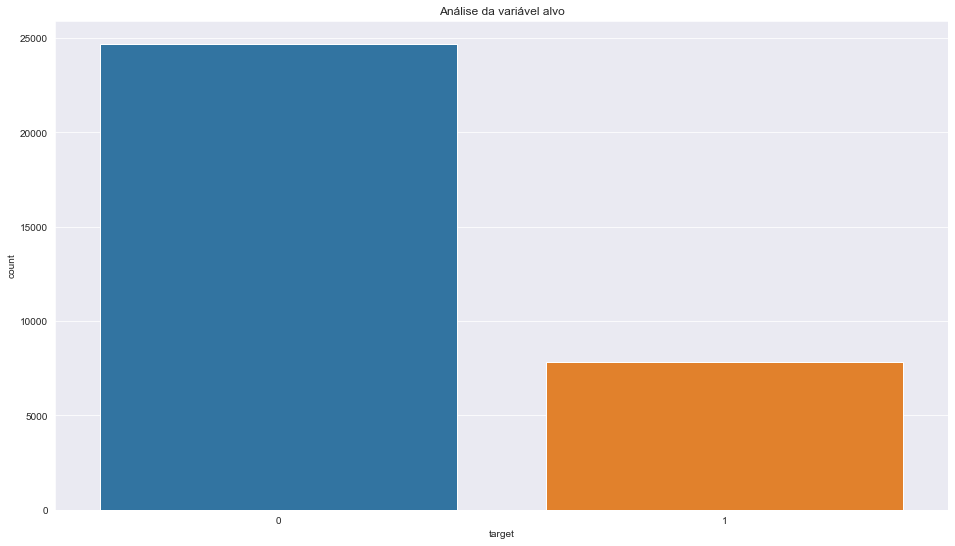

In [67]:
# Análise da variável alvo
plt.figure(figsize = (16, 9))
sns.countplot(data = adults, x = 'target')

plt.title("Análise da variável alvo")

plt.show();

In [68]:
# Análise percentual
print(f"{100*adults.target.mean():.2f}% das pessoas ganham mais de $ 50k por ano")

24.09% das pessoas ganham mais de $ 50k por ano


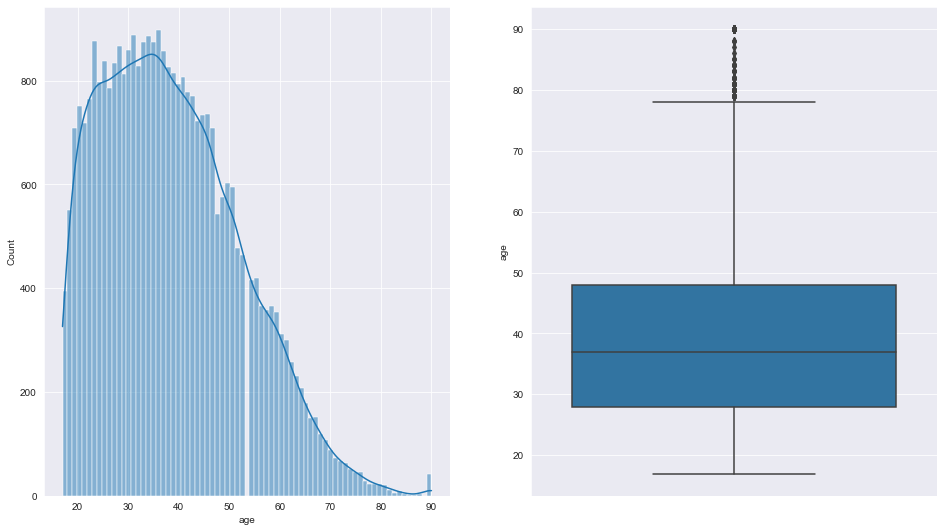

In [69]:
# Análise da distribuição das idades
fig, axs = plt.subplots(1, 2, figsize=(16, 9))

sns.histplot(adults, x = 'age', bins = 75, kde = True, ax = axs[0])
sns.boxplot(data = adults, y = 'age', ax = axs[1])

plt.show();

In [70]:
# Análise estatística pontual - Idade
show_stat("age")

,age
Min,17.000000
Max,90.000000
Desvio Padrão,13.637774
Média,38.585549
Mediana,37.000000


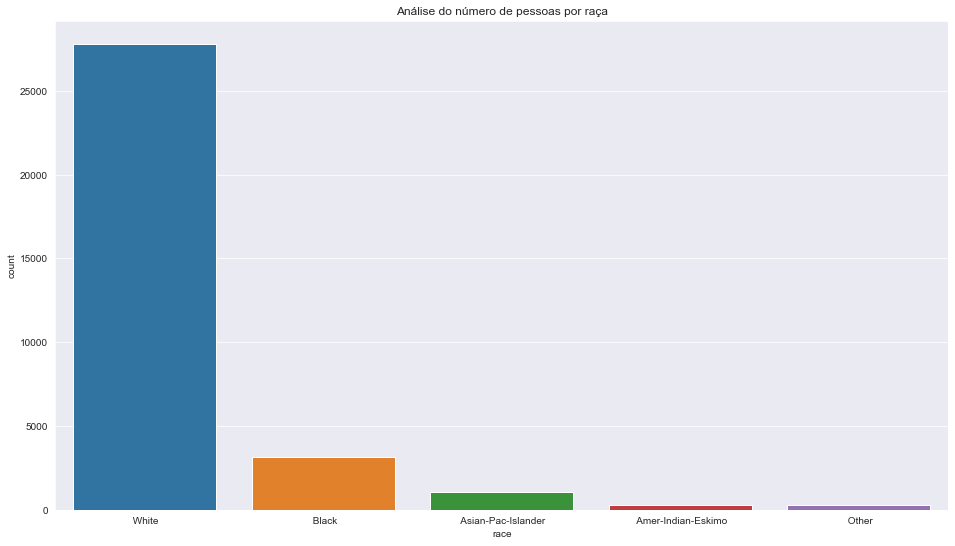

In [71]:
# Análise racial
plt.figure(figsize = (16, 9))
sns.countplot(data = adults, x = 'race')

plt.title("Análise do número de pessoas por raça")

plt.show();

<h2 style="text-align:center">3.2 - Análise Multivariada</h2>

<div style = "text-align:center"><strong>1. Há um salto muito grande no salário de bacharéis, mestres e doutores?</strong></div>

Para responder a essa pergunta, vamos analisar a proporção de bacharéis, mestres e doutores que possuem o salário anual acima de $ 50k ano

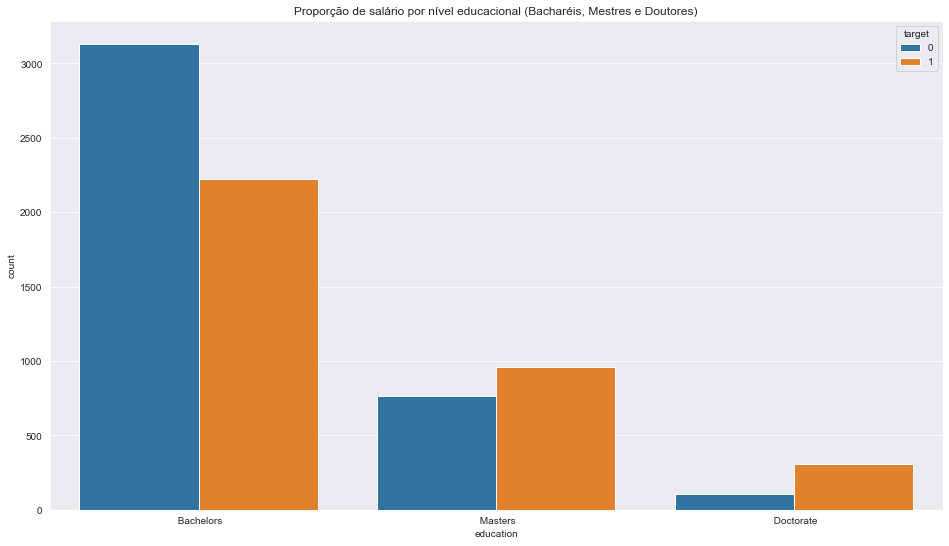

In [72]:
# Plotando o gráfico
plt.figure(figsize = (16, 9))

aux_df = adults[adults['education'].isin([" Bachelors", " Masters", " Doctorate"])]

sns.countplot(data = aux_df, x = 'education', hue = 'target')

plt.title("Proporção de salário por nível educacional (Bacharéis, Mestres e Doutores)")

plt.show()

In [73]:
# Análise percentual
education_list = [" Bachelors", " Masters", " Doctorate"]
lista_auxiliar = ["bacharéis", "mestres", "doutores"]

for indice, education in enumerate(education_list):
    prop = aux_df[aux_df.education == education].target.mean()
    print(f"Porcentagem de {lista_auxiliar[indice]} que ganham mais que $ 50k por ano: {prop*100:.2f}%")

Porcentagem de bacharéis que ganham mais que $ 50k por ano: 41.49%
Porcentagem de mestres que ganham mais que $ 50k por ano: 55.69%
Porcentagem de doutores que ganham mais que $ 50k por ano: 74.09%


Como não temos a quantia exata do salário anual, mas sim uma variável que informa apenas se o salário é maior que um determinado valor ou não, não podemos falar sobre saltos salariais.

Entretanto, é notório que, quanto maior o nível educacional, maior é o número de pessoas que recebem acima de $ 50k por ano.

<div style = "text-align:center"><strong>2. O valor da hora trabalhada aumenta com o aumento da escolaridade? </strong></div>

Note que, novamente, não seremos capazes de responder com precisão devido a ausência de uma variável salário contínua. Entretanto, podemos ter uma ideia analisando a proporção de cada nível educacional que recebe acima de $ 50k por ano, por hora de trabalho semanal.

In [74]:
# Criando lista com as escolaridades em ordem crescente
education_level = [" Preschool", " 1st-4th", " 5th-6th", " 7th-8th", " 9th", " 10th", " 11th", " 12th", " HS-grad",
                   " Some-college", " Assoc-voc", " Assoc-acdm", " Bachelors", " Masters", " Prof-school", " Doctorate"]

In [75]:
# Criando loop para armazenar média de horas por grupo salarial e educacional

avg_hours_0_list = list()
avg_hours_1_list = list()

for education in education_level:
    avg_hours_0 = adults[(adults['education'] == education) & (adults['target'] == 0)]['hours_per_week'].mean()
    avg_hours_1 = adults[(adults['education'] == education) & (adults['target'] == 1)]['hours_per_week'].mean()
    
    avg_hours_0_list.append(avg_hours_0)
    avg_hours_1_list.append(avg_hours_1)

# Criando um dataframe para apresentar o resultado
education_vs_hours = pd.DataFrame({
    "Nível educacional": [x[1:] for x in education_level],
    "Número médio de horas (<=50k)": avg_hours_0_list,
    "Número médio de horas (>50k)": avg_hours_1_list
})

education_vs_hours

,Nível educacional,Número médio de horas (<=50k),Número médio de horas (>50k)
0,Preschool,36.380000,NaN
1,1st-4th,37.837500,48.833333
2,5th-6th,38.487342,46.000000
3,7th-8th,38.828099,47.500000
4,9th,37.667351,44.851852
5,10th,36.574053,43.774194
6,11th,33.322870,45.133333
7,12th,35.035000,44.818182
8,HS-grad,39.727324,45.041219
9,Some-college,37.468962,44.823954


Como não é possível determinar o valor salario/hora, vamos separar o dataset em dois grupos e orderná-lo de acordo com o número médio de horas de trabalho. Os grupos são:
1. Os que recebem um valor menor ou igual a 50k por ano
2. Os que recebem mais de 50k por ano

In [76]:
# Cálculo do percentual médio de aumento do número de horas por semana entre o grupo 1 e 2 (Com exceção do pré-escolar)
percent = np.mean((np.array(avg_hours_1_list[1:]) - np.array(avg_hours_0_list[1:]))/np.array(avg_hours_0_list[1:]))

print(f"O aumento percentual do número de horas do grupo 1 para o grupo 2, para o mesmo nível educacional, foi de {100*percent:.2f}%")

O aumento percentual do número de horas do grupo 1 para o grupo 2, para o mesmo nível educacional, foi de 17.93%


In [77]:
# 1. Recebem um valor menor ou igual a $ 50k:

education_vs_hours.sort_values('Número médio de horas (<=50k)', ascending = True).iloc[:, [0, 1]].head()

,Nível educacional,Número médio de horas (<=50k)
6,11th,33.322870
7,12th,35.035000
0,Preschool,36.380000
5,10th,36.574053
9,Some-college,37.468962


In [78]:
# 2. Recebem mais de $ 50k:

education_vs_hours.sort_values('Número médio de horas (>50k)', ascending = True).iloc[:, [0, 2]].head()

,Nível educacional,Número médio de horas (>50k)
5,10th,43.774194
10,Assoc-voc,43.853186
11,Assoc-acdm,44.256604
7,12th,44.818182
9,Some-college,44.823954


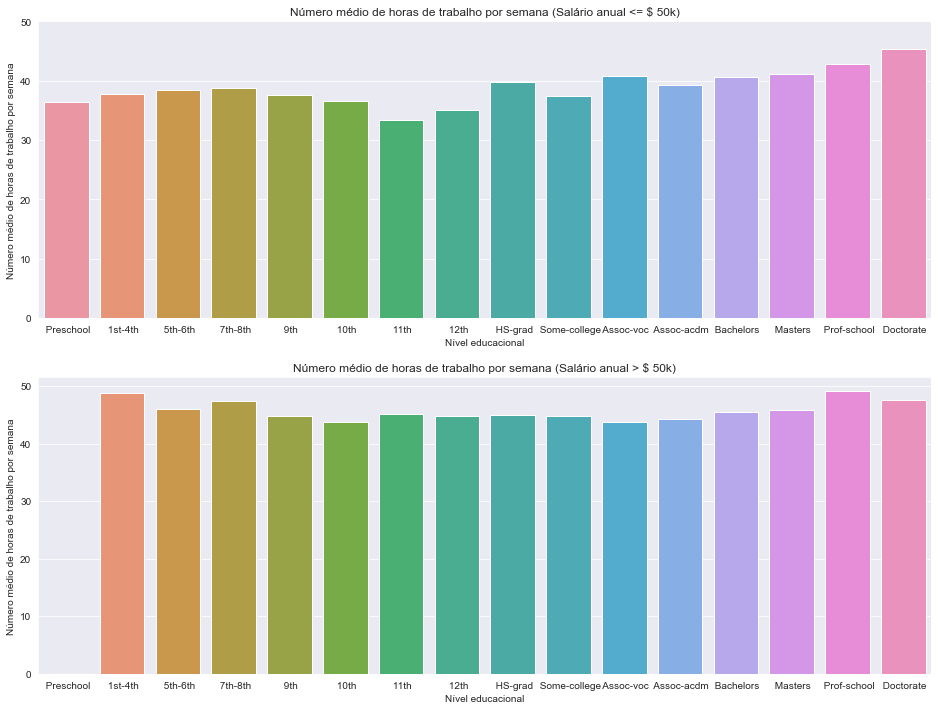

In [79]:
# Plotando o resultado
fig, axs = plt.subplots(2, 1, figsize = (16, 12))

sns.barplot(x = education_level, y = avg_hours_0_list, ax = axs[0])
axs[0].set_title("Número médio de horas de trabalho por semana (Salário anual <= $ 50k)")
axs[0].set_xlabel("Nível educacional")
axs[0].set_ylabel("Número médio de horas de trabalho por semana")
axs[0].set_yticks([0, 10, 20, 30, 40, 50])

sns.barplot(x = education_level, y = avg_hours_1_list, ax = axs[1])
axs[1].set_title("Número médio de horas de trabalho por semana (Salário anual > $ 50k)")
axs[1].set_xlabel("Nível educacional")
axs[1].set_ylabel("Número médio de horas de trabalho por semana")
axs[1].set_yticks([0, 10, 20, 30, 40, 50])

plt.show()

Infelizmente, não é possível extrair tantos insights, visto que há apenas dois grupos salariais e não o valor exato. Isso nos impede de fazer qualquer afirmação com relação ao valor salario/hora. 

Entretanto, é importante notar que para todos os níveis educacionais, com exceção do nível pré-escolar, o número médio de horas trabalhadas por semana, para o mesmo nível educacional, aumentou do grupo que ganha menos ou igual a 50k por ano para o grupo que ganha mais de 50k. Mais precisamente, o aumento foi de 17.93% 

Além disso, não há pessoas com o nível pré-escolar que recebem mais de 50k por ano.

<div style = "text-align:center"><strong>3. Solteiros ganham mais que pessoas em algum tipo de relacionamento? </strong></div>

Para responder a essa pergunta, novamente, não teremos tanta precisão. Porém, podemos separar o dataframe em grupos de pessoas com o mesmo tipo de relacionamento e olhar a proporção, dentro desse grupo, de pessoas que ganham mais de 50k.

In [80]:
# Vamos analisar a variável "relationship" para ver qual dos valroes representam os solteiros
print(f"Valores únicos de 'relationship': \n{adults.relationship.unique()}")

Valores únicos de 'relationship': 
[' Not-in-family' ' Husband' ' Wife' ' Own-child' ' Unmarried'
 ' Other-relative']


In [81]:
# Criando o dataframe auxiliar
rel_df = adults.groupby('relationship')['target'].mean()
rel_df

relationship
 Husband           0.448624
 Not-in-family     0.103232
 Other-relative    0.037717
 Own-child         0.013231
 Unmarried         0.063280
 Wife              0.475128
Name: target, dtype: float64

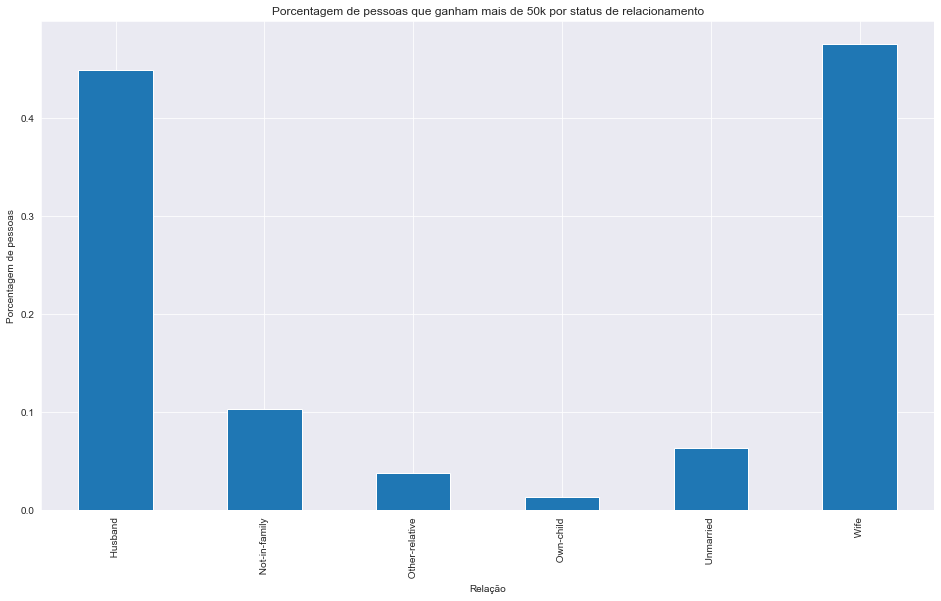

In [82]:
# Plotando o gráfico
plt.figure(figsize = (16, 9))
rel_df.plot.bar()
plt.title("Porcentagem de pessoas que ganham mais de 50k por status de relacionamento")
plt.xlabel("Relação")
plt.ylabel("Porcentagem de pessoas")
plt.show()

Como podemos ver, claramente solteiros não ganham mais que pessoas em relacionamento. Na verdade, maridos e esposas são os dois status de relacionamento que possuem maior porcentagem de pessoas que ganham mais de 50k por ano.

<div style = "text-align:center"><strong>4. Com o aumento do nível de escolaridade, a proporção de homens e mulheres se mantém? E a proporção de brancos e negros? </strong></div>

Inicialmente, vamos responder a primeira pergunta. Depois, vamos aplicar a mesma ideia utilizada na primeira pergunta para responder a segunda.

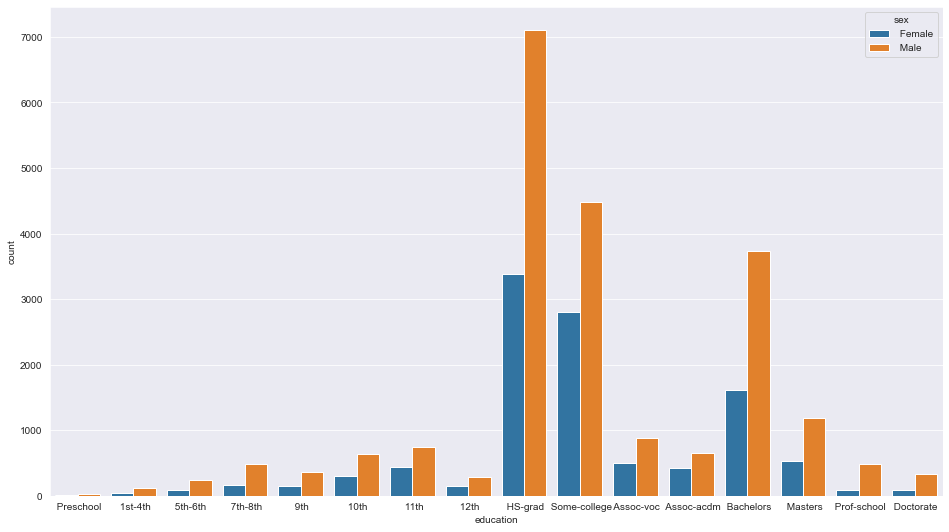

In [83]:
# Criando um gráfico para auxiliar na visualização
plt.figure(figsize = (16, 9))

sns.countplot(data = adults.set_index('education').loc[education_level].reset_index(), x = 'education', hue = 'sex')

plt.show()

Notamos que em todos os níveis educacionais há mais homens que mulheres, porém vamos analisar se a proporção aumenta com o nível escolar.

In [84]:
# Criando listas para armazenar as proporções
male_prop = list()
female_prop = list()

# Criando um loop para calcular as proporções
for education in education_level:
    total = adults.groupby(['education', 'sex'])['sex'].count()[education].sum()
    total_male = adults.groupby(['education', 'sex'])['sex'].count()[education][' Male']
    total_female = adults.groupby(['education', 'sex'])['sex'].count()[education][' Female']
    
    prop_male = total_male/total
    prop_female = total_female/total
    
    male_prop.append(prop_male)
    female_prop.append(prop_female)
    
# Criando um dataframe para armazenar os resultados
male_female_prop = pd.DataFrame({
    "Proporção de homens": male_prop,
    "Proporção de mulheres": female_prop
    },
    index = [x[1:] for x in education_level])

male_female_prop

,Proporção de homens,Proporção de mulheres
Preschool,0.680000,0.320000
1st-4th,0.734940,0.265060
5th-6th,0.746988,0.253012
7th-8th,0.751938,0.248062
9th,0.719844,0.280156
10th,0.683816,0.316184
11th,0.632340,0.367660
12th,0.667436,0.332564
HS-grad,0.677149,0.322851
Some-college,0.615216,0.384784


Agora, vamos utilizar praticamente as mesmas linhas de código para responder a segunda pergunta

In [85]:
# Criando um dataframe apenas com pessoas brancas e negras
race_aux = adults[adults['race'].isin([' White', ' Black'])]

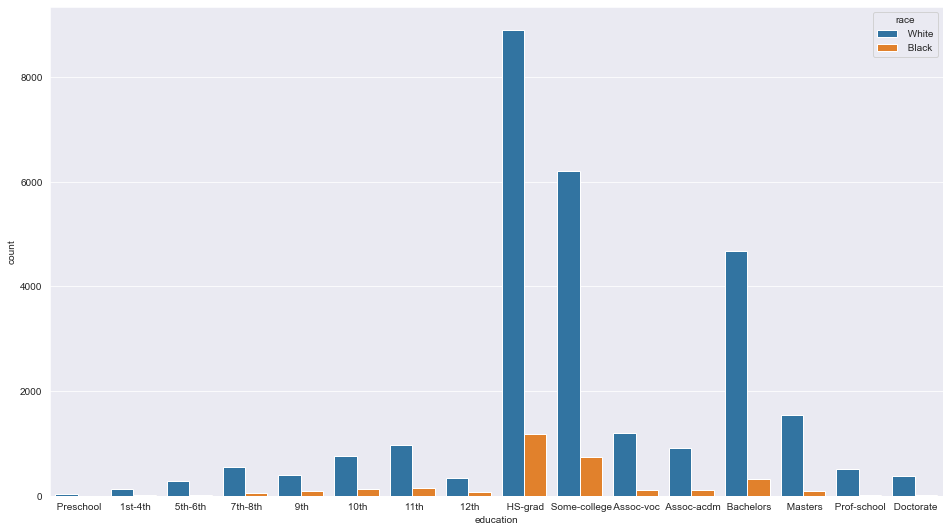

In [86]:
# Criando um gráfico para auxiliar na visualização
plt.figure(figsize = (16, 9))

sns.countplot(data = race_aux.set_index('education').loc[education_level].reset_index(), x = 'education', hue = 'race')

plt.show()

Notamos que em todos os níveis educacionais há mais brancos que negros, porém vamos analisar se a proporção aumenta com o nível escolar.

In [87]:
# Criando listas para armazenar as proporções
white_prop = list()
black_prop = list()

# Criando um loop para calcular as proporções
for education in education_level:
    total = race_aux.groupby(['education', 'race'])['race'].count()[education].sum()
    total_white = race_aux.groupby(['education', 'race'])['race'].count()[education][' White']
    total_black = race_aux.groupby(['education', 'race'])['race'].count()[education][' Black']
    
    prop_white = total_white/total
    prop_black = total_black/total
    
    white_prop.append(prop_white)
    black_prop.append(prop_black)
    
# Criando um dataframe para armazenar os resultados
black_white_prop = pd.DataFrame({
    "Proporção de brancos": white_prop,
    "Proporção de negros": black_prop
    },
    index = [x[1:] for x in education_level])

black_white_prop

,Proporção de brancos,Proporção de negros
Preschool,0.880952,0.119048
1st-4th,0.891892,0.108108
5th-6th,0.929766,0.070234
7th-8th,0.907895,0.092105
9th,0.819106,0.180894
10th,0.851397,0.148603
11th,0.864602,0.135398
12th,0.827160,0.172840
HS-grad,0.883527,0.116473
Some-college,0.892729,0.107271


Com isso, vamos responder as duas perguntas:

Os dois níveis de escolaridade mais altos ("Doctorate" e "Prof-school") são aqueles onde há a menor porcentagem de mulheres. Além disso, a proporção média de mulheres é 30.18%, atingindo um mínimo de 16% no nível "Prof-school". Portanto, fica evidente que a proporção não se mantém quando o nível de escolaridade aumenta. 

Agora, falando sobre a proporção de brancos e negros, temos que os 4 níveis de escolaridade mais altos são aqueles em que há menos negros e 7 dos 9 níveis de escolaridade mais baixos são aqueles em que há mais negros. Além disso, a proporção média de negros é de 10.11%, atingindo um mínimo de 2.84% no nível "Prof-school". Sendo assim, novamente, fica claro que a proporção de negros diminui consideravelmente à medida em que o nível de escolaridade aumenta.

<h1 style="text-align:center">4.0 - Pré-processamento dos dados</h1>

In [102]:
# Dividindo em variáveis preditivas e variável alvo
X = adults.drop(columns = "target", axis = 1)
y = adults.iloc[:, -1]

# Dividindo em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

<h2 style="text-align:center">4.1 - Excluindo features que não iremos utilizar no primeiro ciclo</h2>

In [103]:
# Colunas para excluir
cols_excluir = ["final_weight", "education", "native_country"]

In [104]:
X_train.drop(columns = cols_excluir, axis = 1, inplace = True)

Note que apenas exclui a feature 'education' porque temos a 'education_num', que nada mais é que a 'education' de forma codificada

<h2 style="text-align:center">4.2 - Encoding de variáveis categóricas</h2>

In [105]:
# Analisando a cardinalidade de cada variável
cat_var = X_train.select_dtypes(include = ['object']).columns

for var in cat_var:
    print(f"Cardinalidade de {var}: {X_train[var].nunique()}")

Cardinalidade de workclass: 9
Cardinalidade de marital_status: 7
Cardinalidade de occupation: 15
Cardinalidade de relationship: 6
Cardinalidade de race: 5
Cardinalidade de sex: 2


In [106]:
# Para a variável 'sex', vamos utilizar o map
X_train['sex'] = X_train['sex'].map({" Male": 1, " Female": 0})

In [107]:
# Para o restante, vamos, primeiramente, codificar como "rare" todos os valores com menos de 5% de aparições
cat_var = list(set(cat_var) - set(["sex"]))

for var in cat_var:
    rares = X_train[var].value_counts()[X_train[var].value_counts()/X_train[var].value_counts().sum() < 0.05].index.to_list()
    X_train[var] = X_train[var].apply(lambda x: x if x not in rares else " rare")

In [108]:
# Agora, vamos criar dummies
X_train = pd.get_dummies(data = X_train, columns = list(set(cat_var) - set(["sex"])), drop_first = True)

<h2 style="text-align:center">4.3 - Criando Features</h2>

In [109]:
# Vamos criar uma nova feature chamada 'capital_balance', que será a diferença entre 'capital_gain' e 'capital_loss'
X_train['capital_balance'] = X_train['capital_gain'] - X_train['capital_loss']

In [110]:
# Visualizando a nova variável
X_train[['capital_gain', 'capital_loss', 'capital_balance']].head()

,capital_gain,capital_loss,capital_balance
13011,0,0,0
24494,0,0,0
16923,7298,0,7298
25335,0,1977,-1977
12363,0,0,0


In [111]:
# Com isso, vamos manter apenas a feature 'capital_balance'
X_train.drop(columns = ["capital_gain", "capital_loss"], axis = 1, inplace = True)

<h2 style="text-align:center">4.4 - Escalonando os dados</h2>

In [112]:
# Escalonando com o StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

<h1 style="text-align:center">5.0 - Validação cruzada</h1>

In [189]:
# Dividindo em variáveis preditivas e variável alvo
X = adults.drop(columns = "target", axis = 1)
y = adults.iloc[:, -1]

# Dividindo em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify = y)

In [154]:
# Folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)

In [165]:
# Modelo 1 - Random Forest
rf = RandomForestClassifier(n_estimators = 1000, class_weight = {0: 3.2, 1: 1}, n_jobs = -1, random_state = 0)

In [166]:
# Validação Cruzada para a Random Forest
validacao_cruzada(X_train, y_train, rf)

-=-=-= Fold 1 -=-=-=
-=-=-=-=-=-=-=-=-=-=-=

Acurácia: 0.8472008781558726
F1-Score: 0.6627906976744187

-=-=-= Fold 2 -=-=-=
-=-=-=-=-=-=-=-=-=-=-=

Acurácia: 0.8419319429198683
F1-Score: 0.6432111000991081

-=-=-= Fold 3 -=-=-=
-=-=-=-=-=-=-=-=-=-=-=

Acurácia: 0.842371020856202
F1-Score: 0.6434955312810328

-=-=-= Fold 4 -=-=-=
-=-=-=-=-=-=-=-=-=-=-=

Acurácia: 0.8412733260153678
F1-Score: 0.6390414378432352

-=-=-= Fold 5 -=-=-=
-=-=-=-=-=-=-=-=-=-=-=

Acurácia: 0.837980241492865
F1-Score: 0.6335650446871897

-=-=-=-=-=-=-=-=-=
Resultado Médio Final
Acurácia: 0.8421514818880352
Precisão: 0.7044704262278387
Revocação: 0.593953703842073
F1-Score: 0.644420762316997
ROC AUC: 0.7574407885142607


In [167]:
# Modelo 2 - XGBoost Classifier
xgboost = GradientBoostingClassifier(n_estimators = 1000, random_state = 0)

In [168]:
# Validação Cruzada para o Gradient Boosting
validacao_cruzada(X_train, y_train, xgboost)

-=-=-= Fold 1 -=-=-=
-=-=-=-=-=-=-=-=-=-=-=

Acurácia: 0.868715697036224
F1-Score: 0.7065750736015702

-=-=-= Fold 2 -=-=-=
-=-=-=-=-=-=-=-=-=-=-=

Acurácia: 0.8630076838638858
F1-Score: 0.6944172380019589

-=-=-= Fold 3 -=-=-=
-=-=-=-=-=-=-=-=-=-=-=

Acurácia: 0.868715697036224
F1-Score: 0.7027833001988071

-=-=-= Fold 4 -=-=-=
-=-=-=-=-=-=-=-=-=-=-=

Acurácia: 0.8709110867178924
F1-Score: 0.7042253521126761

-=-=-= Fold 5 -=-=-=
-=-=-=-=-=-=-=-=-=-=-=

Acurácia: 0.8660812294182217
F1-Score: 0.6916076845298282

-=-=-=-=-=-=-=-=-=
Resultado Médio Final
Acurácia: 0.8674862788144896
Precisão: 0.7703750382995704
Revocação: 0.6415204241406851
F1-Score: 0.6999217296889682
ROC AUC: 0.79036369218872


In [169]:
# Modelo 3 - Regressão Logística
rl = LogisticRegression(class_weight = {0: 3.2, 1: 1}, n_jobs = -1, random_state = 0)

In [170]:
# Validação Cruzada para a Regressão Logística
validacao_cruzada(X_train, y_train, rl)

-=-=-= Fold 1 -=-=-=
-=-=-=-=-=-=-=-=-=-=-=

Acurácia: 0.8162458836443469
F1-Score: 0.4294478527607362

-=-=-= Fold 2 -=-=-=
-=-=-=-=-=-=-=-=-=-=-=

Acurácia: 0.8125137211855105
F1-Score: 0.396039603960396

-=-=-= Fold 3 -=-=-=
-=-=-=-=-=-=-=-=-=-=-=

Acurácia: 0.8133918770581778
F1-Score: 0.4064245810055866

-=-=-= Fold 4 -=-=-=
-=-=-=-=-=-=-=-=-=-=-=

Acurácia: 0.8100987925356751
F1-Score: 0.38869257950530034

-=-=-= Fold 5 -=-=-=
-=-=-=-=-=-=-=-=-=-=-=

Acurácia: 0.8140504939626784
F1-Score: 0.40141342756183745

-=-=-=-=-=-=-=-=-=
Resultado Médio Final
Acurácia: 0.8132601536772779
Precisão: 0.873339152986029
Revocação: 0.26335294303224727
F1-Score: 0.40440360895877125
ROC AUC: 0.6255740511832328


In [171]:
# Modelo 4 - SVC
svc = SVC(class_weight = {0: 3.2, 1: 1}, random_state = 0)

In [172]:
# Validação Cruzada para a SVC
validacao_cruzada(X_train, y_train, svc)

-=-=-= Fold 1 -=-=-=
-=-=-=-=-=-=-=-=-=-=-=

Acurácia: 0.8100987925356751
F1-Score: 0.3843416370106761

-=-=-= Fold 2 -=-=-=
-=-=-=-=-=-=-=-=-=-=-=

Acurácia: 0.8030735455543359
F1-Score: 0.33702882483370283

-=-=-= Fold 3 -=-=-=
-=-=-=-=-=-=-=-=-=-=-=

Acurácia: 0.8079034028540066
F1-Score: 0.3654822335025381

-=-=-= Fold 4 -=-=-=
-=-=-=-=-=-=-=-=-=-=-=

Acurácia: 0.8105378704720088
F1-Score: 0.3804737975592247

-=-=-= Fold 5 -=-=-=
-=-=-=-=-=-=-=-=-=-=-=

Acurácia: 0.8070252469813392
F1-Score: 0.35224760501105384

-=-=-=-=-=-=-=-=-=
Resultado Médio Final
Acurácia: 0.8077277716794731
Precisão: 0.8963900810851315
Revocação: 0.22853983292735774
F1-Score: 0.36391481958343913
ROC AUC: 0.6100474045085724


In [175]:
# Modelo 5 - XGBoost Classifier
xgb = XGBClassifier(scale_pos_weight = 3.2, n_jobs = -1, n_estimators = 1000, random_state = 0)

In [176]:
# Validação Cruzada para o XGBoost Classifier
validacao_cruzada(X_train, y_train, xgb)

-=-=-= Fold 1 -=-=-=
-=-=-=-=-=-=-=-=-=-=-=

Acurácia: 0.8362239297475302
F1-Score: 0.6889074228523769

-=-=-= Fold 2 -=-=-=
-=-=-=-=-=-=-=-=-=-=-=

Acurácia: 0.823271130625686
F1-Score: 0.66967583093968

-=-=-= Fold 3 -=-=-=
-=-=-=-=-=-=-=-=-=-=-=

Acurácia: 0.8355653128430296
F1-Score: 0.6822231650403054

-=-=-= Fold 4 -=-=-=
-=-=-=-=-=-=-=-=-=-=-=

Acurácia: 0.8384193194291987
F1-Score: 0.6857386848847139

-=-=-= Fold 5 -=-=-=
-=-=-=-=-=-=-=-=-=-=-=

Acurácia: 0.8230515916575192
F1-Score: 0.6691297208538588

-=-=-=-=-=-=-=-=-=
Resultado Médio Final
Acurácia: 0.8313062568605927
Precisão: 0.6273126349243532
Revocação: 0.7406611507124081
F1-Score: 0.679134964914187
ROC AUC: 0.8003687808363047


In [190]:
# Métricas
acuracias = [0.8421514818880352, 0.8674862788144896, 0.8132601536772779, 0.8077277716794731, 0.8313062568605927]
f1score = [0.644420762316997, 0.6999217296889682, 0.40440360895877125, 0.36391481958343913, 0.679134964914187]
rocauc = [0.7574407885142607, 0.79036369218872, 0.6255740511832328, 0.6100474045085724, 0.8003687808363047]
nomes = ["Random Forest", "Gradient Boosting", "Regressão Logística", "SVC", "XBG Classifier"]

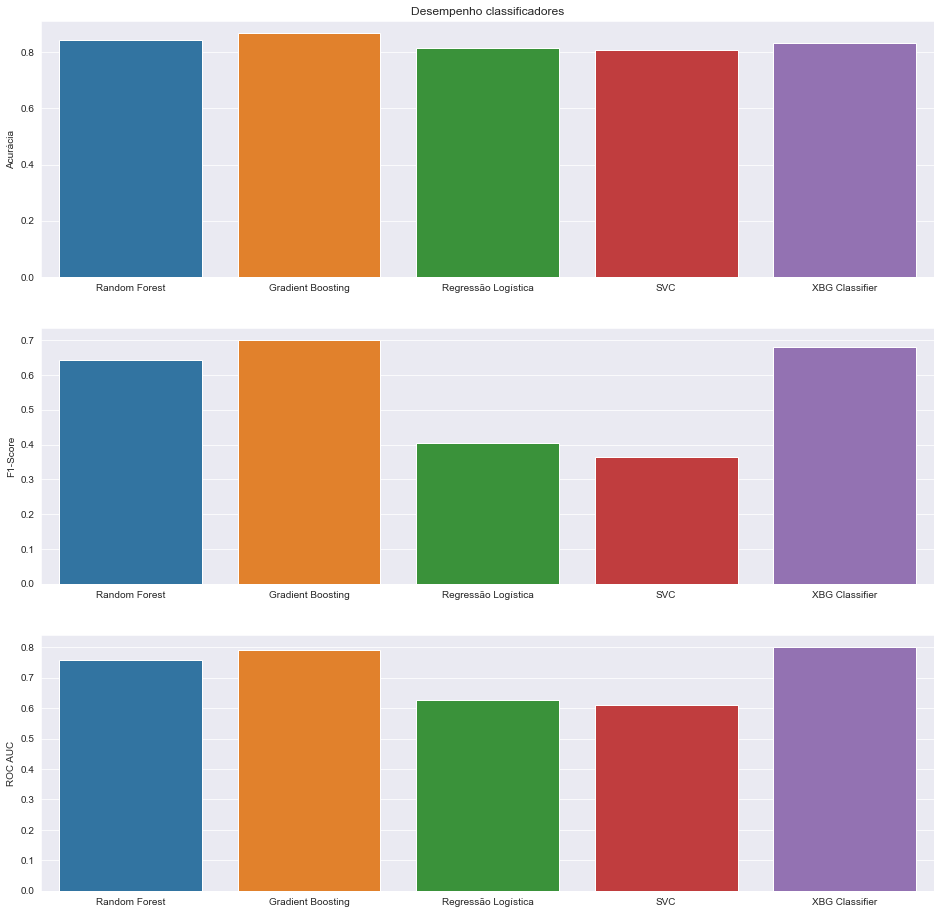

In [201]:
# Resumo (gráfico)
fig, axs = plt.subplots(3, 1, figsize = (16, 16))

sns.barplot(x = nomes, y = acuracias, ax = axs[0])
axs[0].set_ylabel("Acurácia")
axs[0].set_title("Desempenho classificadores")

sns.barplot(x = nomes, y = f1score, ax = axs[1])
axs[1].set_ylabel("F1-Score")

sns.barplot(x = nomes, y = rocauc, ax = axs[2])
axs[2].set_ylabel("ROC AUC")

plt.show()

<h1 style="text-align:center">6.0 - Verificação do desempenho no conjunto de testes</h1>

In [202]:
# Dividindo em variáveis preditivas e variável alvo
X = adults.drop(columns = "target", axis = 1)
y = adults.iloc[:, -1]

# Dividindo em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify = y)

In [203]:
# Pré-processamento
X_train, X_test = preprocess(X_train, X_test)

In [204]:
# Treinando o modelo
xgboost = GradientBoostingClassifier(n_estimators = 1000, random_state = 0)

xgboost.fit(X_train, y_train)

GradientBoostingClassifier(n_estimators=1000, random_state=0)

In [205]:
# Prevendo no conjunto de testes
y_pred = xgboost.predict(X_test)

In [208]:
# Resultado
acuracia, precision, recall, f1score, rocaucscore = metricas(y_test, y_pred)

print(f"Acurácia: {acuracia}\nPrecisão: {precision}\nRevocação: {recall}\nF1-Score: {f1score}\nROC AUC: {rocaucscore}")

Acurácia: 0.8690842040565457
Precisão: 0.7753846153846153
Revocação: 0.6428571428571429
F1-Score: 0.702928870292887
ROC AUC: 0.791873915558126


<h1 style="text-align:center">7.0 - Conclusão</h1>

Como vimos, nosso melhor modelo alcançou 86.91% de acurácia, 70.29% de F1-Score e 79.19% de ROC AUC.

Para um modelo sem ensemble, tunagem de parâmetros e qualquer outro tipo de otimização, é um bom resultado para o primeiro ciclo do CRISP-DM.